In [1]:
### mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir("/content/drive/My Drive/WatNet")
# # !pip install rasterio

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import glob
import time
import random
import numpy as np
import tensorflow as tf
from notebooks import config
import matplotlib.pyplot as plt
from dataloader.img_aug import img_aug
from utils.acc_eval import acc_patch
from utils.imgShow import imgShow, imsShow
from model.seg_model.watnet import watnet
from model.seg_model.deeplabv3_plus import deeplabv3_plus
from model.seg_model.deepwatermapv2 import deepwatermapv2
from dataloader.tfrecord_io import parse_image,parse_shape,toPatchPair



## Data loading
### _Load and parse the tfrecord data_

In [6]:
### data loading from .tfrecord file
path_tra_data = 'data/tfrecord-s2/tra_data.tfrecords'
path_val_data = 'data/tfrecord-s2/val_data.tfrecords'
## training data
tra_dset = tf.data.TFRecordDataset(path_tra_data)
tra_dset = tra_dset.map(parse_image).map(parse_shape)\
            .cache()\
            .map(toPatchPair)\
            .map(img_aug)
tra_dset = tra_dset.shuffle(config.buffer_size).batch(config.batch_size)

## validation data
val_dset = tf.data.TFRecordDataset(path_val_data)
val_dset = val_dset.map(parse_image).map(parse_shape)\
            .map(toPatchPair)
val_dset = val_dset.batch(4)


In [4]:
# # for i in range(5):
# start = time.time()
# i = 1
# for patch, truth in val_dset.take(1):
#     i+=1
# imsShow(img_list=[patch[0], truth[0]], 
#     img_name_list=['patch', 'truth'],
#     clip_list=[2,0]
#     )
# plt.show()
# print('num:', i)
# print('time:', time.time()-start)


In [7]:
## model configuration
# model = watnet(input_shape=(config.patch_size, config.patch_size, config.num_bands), nclasses=2)
# model = deeplabv3_plus(nclasses=2)
model = deepwatermapv2(min_width=4)


In [8]:
'''------1. train step------'''
# @tf.function
def train_step(model, loss_fun, optimizer, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=True)
        loss = loss_fun(y, y_pre)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    config.tra_loss.update_state(loss)
    config.tra_oa.update_state(y, y_pre)
    config.tra_miou.update_state(y, y_pre)
    return config.tra_loss.result(), config.tra_oa.result(), config.tra_miou.result()

'''------2. test step------'''
# @tf.function
def test_step(model, loss_fun, x, y):
    with tf.GradientTape() as tape:
        y_pre = model(x, training=False)
        loss = loss_fun(y, y_pre)
    config.val_loss.update_state(loss) 
    config.val_oa.update_state(y, y_pre)
    config.val_miou.update_state(y, y_pre)
    return config.val_loss.result(), config.val_oa.result(), config.val_miou.result()

'''------3. train loops------'''
def train_loops(model, loss_fun, optimizer, tra_dset, val_dset, epochs):
    max_miou_pre = 0.8
    for epoch in range(epochs):
        start = time.time()
        ###--- train the model ---
        for x_batch, y_batch in tra_dset:
            tra_loss_epoch,tra_oa_epoch,tra_miou_epoch = train_step(model, loss_fun, optimizer, x_batch, y_batch)        
        ### --- test the model ---
        for x_batch, y_batch in val_dset:
            val_loss_epoch, val_oa_epoch, val_miou_epoch = test_step(model, loss_fun, x_batch, y_batch)
        ### --- update the metrics ---
        config.tra_loss.reset_states(), config.tra_oa.reset_states(), config.tra_miou.reset_states()
        config.val_loss.reset_states(), config.val_oa.reset_states(), config.val_miou.reset_states()
        format = 'Ep {}: traLoss:{:.3f},traOA:{:.3f},traMIoU:{:.3f},valLoss:{:.3f},valOA:{:.3f},valMIoU:{:.3f},time:{:.0f}s'
        print(format.format(epoch + 1, tra_loss_epoch, tra_oa_epoch, tra_miou_epoch, val_loss_epoch, val_oa_epoch, val_miou_epoch, time.time() - start))

        ## --- visualize the results ---
        if epoch%20 == 0:
            i = np.random.randint(config.batch_size)
            for val_patch, val_truth in val_dset.take(1):
                plt.figure(figsize=(10,4))
                pre = model(val_patch, training=False)
                imsShow(img_list=[val_patch.numpy()[i], val_truth.numpy()[i], pre.numpy()[i]], \
                        img_name_list=['val_patch', 'val_truth', 'prediction'], \
                        clip_list=[2,0,0],\
                        color_bands_list=None)
                plt.show()


Ep 1: traLoss:0.506,traOA:0.800,traMIoU:0.642,valLoss:440.204,valOA:0.586,valMIoU:0.356,time:81s


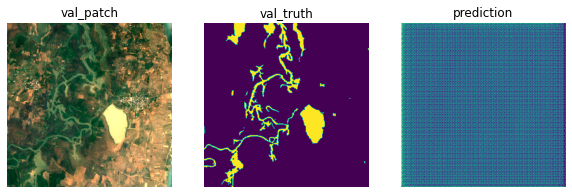

Ep 2: traLoss:0.458,traOA:0.866,traMIoU:0.730,valLoss:19.935,valOA:0.410,valMIoU:0.255,time:20s
Ep 3: traLoss:0.462,traOA:0.865,traMIoU:0.729,valLoss:6.424,valOA:0.395,valMIoU:0.245,time:30s
Ep 4: traLoss:0.443,traOA:0.901,traMIoU:0.780,valLoss:1.554,valOA:0.444,valMIoU:0.283,time:30s
Ep 5: traLoss:0.423,traOA:0.910,traMIoU:0.805,valLoss:1.020,valOA:0.513,valMIoU:0.338,time:20s
Ep 6: traLoss:0.422,traOA:0.909,traMIoU:0.798,valLoss:0.789,valOA:0.559,valMIoU:0.380,time:30s
Ep 7: traLoss:0.418,traOA:0.914,traMIoU:0.806,valLoss:0.908,valOA:0.526,valMIoU:0.351,time:29s
Ep 8: traLoss:0.425,traOA:0.909,traMIoU:0.788,valLoss:1.056,valOA:0.319,valMIoU:0.188,time:20s
Ep 9: traLoss:0.404,traOA:0.928,traMIoU:0.834,valLoss:0.741,valOA:0.556,valMIoU:0.320,time:20s
Ep 10: traLoss:0.416,traOA:0.908,traMIoU:0.794,valLoss:0.606,valOA:0.735,valMIoU:0.372,time:19s
Ep 11: traLoss:0.384,traOA:0.932,traMIoU:0.845,valLoss:0.542,valOA:0.736,valMIoU:0.369,time:30s
Ep 12: traLoss:0.377,traOA:0.942,traMIoU:0.863,

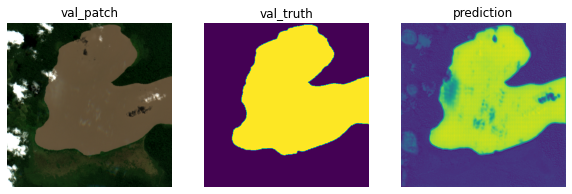

Ep 22: traLoss:0.331,traOA:0.949,traMIoU:0.877,valLoss:0.376,valOA:0.850,valMIoU:0.592,time:30s
Ep 23: traLoss:0.326,traOA:0.950,traMIoU:0.880,valLoss:0.368,valOA:0.854,valMIoU:0.603,time:29s
Ep 24: traLoss:0.342,traOA:0.937,traMIoU:0.851,valLoss:0.341,valOA:0.933,valMIoU:0.814,time:30s
Ep 25: traLoss:0.327,traOA:0.941,traMIoU:0.859,valLoss:0.300,valOA:0.968,valMIoU:0.910,time:20s
Ep 26: traLoss:0.333,traOA:0.940,traMIoU:0.853,valLoss:0.285,valOA:0.967,valMIoU:0.908,time:20s
Ep 27: traLoss:0.335,traOA:0.937,traMIoU:0.852,valLoss:0.336,valOA:0.914,valMIoU:0.763,time:29s
Ep 28: traLoss:0.301,traOA:0.948,traMIoU:0.877,valLoss:0.296,valOA:0.972,valMIoU:0.924,time:31s
Ep 29: traLoss:0.339,traOA:0.926,traMIoU:0.828,valLoss:0.492,valOA:0.852,valMIoU:0.701,time:30s
Ep 30: traLoss:0.327,traOA:0.938,traMIoU:0.847,valLoss:0.610,valOA:0.800,valMIoU:0.630,time:20s
Ep 31: traLoss:0.311,traOA:0.939,traMIoU:0.854,valLoss:0.300,valOA:0.963,valMIoU:0.902,time:20s
Ep 32: traLoss:0.303,traOA:0.949,traMIoU

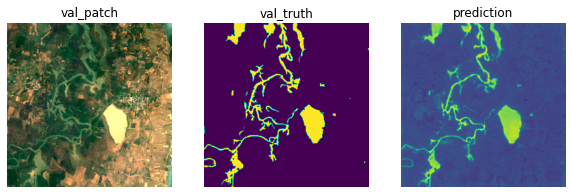

Ep 42: traLoss:0.271,traOA:0.959,traMIoU:0.896,valLoss:0.227,valOA:0.981,valMIoU:0.949,time:20s
Ep 43: traLoss:0.256,traOA:0.955,traMIoU:0.891,valLoss:0.215,valOA:0.979,valMIoU:0.944,time:20s
Ep 44: traLoss:0.261,traOA:0.959,traMIoU:0.895,valLoss:0.240,valOA:0.984,valMIoU:0.956,time:29s
Ep 45: traLoss:0.287,traOA:0.941,traMIoU:0.853,valLoss:0.223,valOA:0.973,valMIoU:0.929,time:29s
Ep 46: traLoss:0.273,traOA:0.944,traMIoU:0.866,valLoss:0.221,valOA:0.965,valMIoU:0.910,time:20s
Ep 47: traLoss:0.270,traOA:0.954,traMIoU:0.879,valLoss:0.228,valOA:0.962,valMIoU:0.903,time:30s
Ep 48: traLoss:0.244,traOA:0.956,traMIoU:0.895,valLoss:0.197,valOA:0.981,valMIoU:0.948,time:30s
Ep 49: traLoss:0.251,traOA:0.955,traMIoU:0.892,valLoss:0.200,valOA:0.977,valMIoU:0.939,time:20s
Ep 50: traLoss:0.259,traOA:0.953,traMIoU:0.883,valLoss:0.184,valOA:0.980,valMIoU:0.946,time:20s
Ep 51: traLoss:0.264,traOA:0.950,traMIoU:0.875,valLoss:0.196,valOA:0.975,valMIoU:0.935,time:29s
Ep 52: traLoss:0.226,traOA:0.967,traMIoU

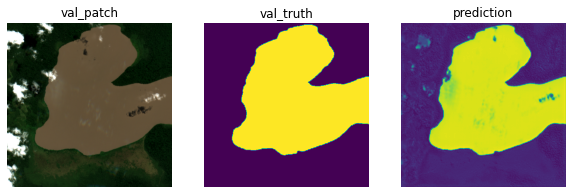

Ep 62: traLoss:0.246,traOA:0.944,traMIoU:0.869,valLoss:0.184,valOA:0.968,valMIoU:0.915,time:19s
Ep 63: traLoss:0.235,traOA:0.955,traMIoU:0.879,valLoss:0.347,valOA:0.880,valMIoU:0.747,time:19s
Ep 64: traLoss:0.235,traOA:0.952,traMIoU:0.878,valLoss:0.188,valOA:0.971,valMIoU:0.924,time:30s
Ep 65: traLoss:0.247,traOA:0.939,traMIoU:0.839,valLoss:0.160,valOA:0.980,valMIoU:0.945,time:20s
Ep 66: traLoss:0.223,traOA:0.960,traMIoU:0.899,valLoss:0.184,valOA:0.976,valMIoU:0.935,time:29s
Ep 67: traLoss:0.234,traOA:0.951,traMIoU:0.882,valLoss:0.204,valOA:0.957,valMIoU:0.891,time:29s
Ep 68: traLoss:0.233,traOA:0.954,traMIoU:0.881,valLoss:0.263,valOA:0.923,valMIoU:0.821,time:20s
Ep 69: traLoss:0.210,traOA:0.963,traMIoU:0.905,valLoss:0.181,valOA:0.976,valMIoU:0.935,time:20s
Ep 70: traLoss:0.225,traOA:0.954,traMIoU:0.885,valLoss:0.173,valOA:0.984,valMIoU:0.956,time:20s
Ep 71: traLoss:0.211,traOA:0.960,traMIoU:0.901,valLoss:0.166,valOA:0.980,valMIoU:0.945,time:20s
Ep 72: traLoss:0.206,traOA:0.961,traMIoU

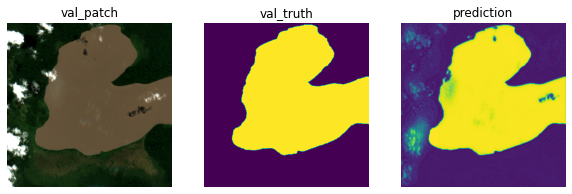

Ep 82: traLoss:0.190,traOA:0.963,traMIoU:0.905,valLoss:0.172,valOA:0.975,valMIoU:0.932,time:19s
Ep 83: traLoss:0.199,traOA:0.962,traMIoU:0.901,valLoss:0.169,valOA:0.982,valMIoU:0.950,time:30s
Ep 84: traLoss:0.184,traOA:0.965,traMIoU:0.918,valLoss:0.163,valOA:0.983,valMIoU:0.953,time:29s
Ep 85: traLoss:0.196,traOA:0.961,traMIoU:0.895,valLoss:0.171,valOA:0.977,valMIoU:0.938,time:30s
Ep 86: traLoss:0.184,traOA:0.964,traMIoU:0.904,valLoss:0.165,valOA:0.980,valMIoU:0.947,time:30s
Ep 87: traLoss:0.183,traOA:0.966,traMIoU:0.913,valLoss:0.170,valOA:0.982,valMIoU:0.951,time:30s
Ep 88: traLoss:0.185,traOA:0.968,traMIoU:0.915,valLoss:0.160,valOA:0.975,valMIoU:0.934,time:30s
Ep 89: traLoss:0.190,traOA:0.961,traMIoU:0.900,valLoss:0.159,valOA:0.974,valMIoU:0.931,time:29s
Ep 90: traLoss:0.180,traOA:0.961,traMIoU:0.906,valLoss:0.148,valOA:0.977,valMIoU:0.939,time:30s
Ep 91: traLoss:0.218,traOA:0.942,traMIoU:0.854,valLoss:0.140,valOA:0.981,valMIoU:0.948,time:20s
Ep 92: traLoss:0.186,traOA:0.968,traMIoU

In [9]:
## training
train_loops(model=model, \
            loss_fun=config.loss_bce, \
            optimizer=config.opt_adam, \
            tra_dset=tra_dset, \
            val_dset=val_dset, \
            epochs=config.epochs)


In [ ]:
### model saving
# path_save = 'models/pretrained_model/watnet_tmp'
# model.save(path_save)

